<a href="https://colab.research.google.com/github/gatestonjohns/SchoolWatch_ML/blob/main/SchoolWatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SchoolWatch - Final Project

For our project we will be classifying students by college using a combination of WLAN trace data and spatio-temporal commonalities. We will be supplementing this data with official UF enrollment statistics and relevant class rosters to attempt to validate our results. We plan to use this data to draw patterns about the daily lives of students from different colleges and get further insight on disparities between college students.

Note: To view hidden cells click `# cells hidden` or use the arrows on the side of each section header.

### Library Imports and Installs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/NetML/Data

/content/drive/MyDrive/NetML/Data


In [ ]:
pip install -U pandasql

In [ ]:
pip install scikit-learn-extra

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium as fol
import math
import itertools
import seaborn as sns
from math import sqrt
from pandasql import sqldf
import re
from mpl_toolkits import mplot3d
from sklearn import neighbors, datasets, preprocessing
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn_extra.cluster import KMedoids

### Importing/Cleaning Trace Data for Week Starting 4.7.12 and Schedule Data

Removes illogical rows and all rows not within class time.

This section also adds a `bldgPrefix`, `roomNum` column.

Cleaned dataframes named in form `cleanedA##` where # is the day of month. Note this only goes for April ('A').

Cleaned dataframes within class times (per UF schedule) are named in the form `classtimeA##`.

Cleaned dataframes of the schedule of courses on a particular school day (M-F) are in the form `#####Classes`.

In [ ]:
# dataframes
# week long traces
a7df = pd.read_csv("DHCP_April_2012_devType-day-7.csv") # This is a Saturday
a8df = pd.read_csv("DHCP_April_2012_devType-day-8.csv") # This is a Sunday
a9df = pd.read_csv("DHCP_April_2012_devType-day-9.csv") # This is a Monday
a10df = pd.read_csv("DHCP_April_2012_devType-day-10.csv") # This is a Tuesday
a11df = pd.read_csv("DHCP_April_2012_devType-day-11.csv") # This is a Wednesday
a12df = pd.read_csv("DHCP_April_2012_devType-day-12.csv") # This is a Thursday
a13df = pd.read_csv("DHCP_April_2012_devType-day-13.csv") # This is a Friday

# schedule of courses for Spring 2012
schedule = pd.read_csv("Edited_Group5_Classes_Spring_2012.csv")
# departments associated with the college they fall under
colleges = pd.read_csv("Departments_Colleges.csv")

# building prefixes and names
buildings = pd.read_csv("prefix_lat_lon_name_category.csv")

In [ ]:
# function to remove everything after first '-' in APNAME
def cleanAPNAME(name):
  return name[0:name.find("-")]

In [ ]:
# function to get the first part of APNAME (building prefix)
def splitter(apname):
  temp = re.split('\d+', apname)

  bldg = temp[0]

  return bldg

In [ ]:
# hall is at the end of some numbers ex. fac208hall becomes 208hall so I removed the last 4 chars
def removeHall(number):
  if "hall" in number:
    number = number[:-4]

  return number

In [ ]:
# streamlined function for cleaning traces
def dataframeCleaner(df):
  # removing unneccessary columns
  cleaned = df.drop(columns=['userIP', 'day'])
  # getting rid of unknown APNAMEs
  cleaned = cleaned.drop(cleaned[cleaned.APNAME == "unknown"].index)
  # getting rid of AP0007 APNAMEs
  cleaned = cleaned.drop(cleaned[cleaned.APNAME == "AP0007"].index)
  # removing zero length sessions - MIGHT BE GOOD TO DO < x SESSIONS, NEED TO DO SOME RESEARCH
  # low duration sessions can just be ping ponging between different APs
  # UPDATE: now dropping sessions that are less than 15 minutes
  cleaned = cleaned.drop(cleaned[cleaned["endTime"] - cleaned["startTime"] < 900].index)
  # removing everything after first '-' in APNAME
  cleaned["APNAME"] = cleaned["APNAME"].apply(cleanAPNAME)
  # getting rid of weiclocktower APNAMEs
  cleaned = cleaned.drop(cleaned[cleaned.APNAME == "weiclocktower"].index)
  # gets starting abbreviation from APNAME
  cleaned["Building"] = cleaned["APNAME"].apply(splitter)
  # gets number from APNAME by doing APNAME - Building = Number
  # issue with this is in row 0 there is 208hall, need to find a way to remove the extra info
  cleaned["Number"] = [a.replace(b, '').strip() for a, b in zip(cleaned["APNAME"], cleaned["Building"])]
   # gets rid of hall from number
  cleaned["Number"] = cleaned["Number"].apply(removeHall)

  return cleaned

In [ ]:
# cleaning a9-a13 dataframe
# https://stackoverflow.com/questions/54828801/how-to-subtract-string-type-columns-values-from-another-column-in-pandas

# runs dataframe cleaner across all seven dataframes
cleanedA7 = dataframeCleaner(a7df)
cleanedA8 = dataframeCleaner(a8df)
cleanedA9 = dataframeCleaner(a9df)
cleanedA10 = dataframeCleaner(a10df)
cleanedA11 = dataframeCleaner(a11df)
cleanedA12 = dataframeCleaner(a12df)
cleanedA13 = dataframeCleaner(a13df)

In [ ]:
# gets rid of earlier than 7:25am EST and later than 10:10pm traces
def timeClean(df, day):
  # used to convert EPOCH time scale for M, T, W, R, F traces
  # M is specified by a 1
  if day == 1:
    offset = 0
  elif day == 2:
    offset = 86400
  elif day == 3:
    offset = 86400 * 2
  elif day == 4:
    offset = 86400 * 3
  elif day == 5:
    offset = 86400 * 4

  # cleans all times before 7:25am EST on specified day
  temp = df.drop(df[df.startTime < 1333970700 + offset].index)
  # cleans all times after 10:10pm EST on specified day
  temp = temp.drop(temp[temp.startTime > 1334023800 + offset].index)

  return temp

In [ ]:
# classtime a9-13 dataframe
# https://www.epochconverter.com

# runs the time clean function to get the traces within UF's class times
classtimeA9 = timeClean(cleanedA9, 1)
classtimeA10 = timeClean(cleanedA10, 2)
classtimeA11 = timeClean(cleanedA11, 3)
classtimeA12 = timeClean(cleanedA12, 4)
classtimeA13 = timeClean(cleanedA13, 5)

In [ ]:
# function to translate start period into EPOCH time
# https://www.epochconverter.com
# https://registrar.ufl.edu/courses/class-times

def translateStart(startTime, day):
  # translates each day of the week by a numerical offset
  # M = 1, T = 2, W = 3, ...
  if day == "1":
    offset = 0
  elif day == "2":
    offset = 86400
  elif day == "3":
    offset = 86400 * 2
  elif day == "4":
    offset = 86400 * 3
  elif day == "5":
    offset = 86400 * 4

  epoch = ""

  # handles periods like 1-2 (get 1) vs 1
  if "-" in startTime:
    temp = startTime[0:startTime.find("-")]
  else:
    temp = startTime

  # converts period into EPOCH time
  if(temp == "1"):
    epoch = 1333970700 + offset
  elif(temp == "2"):
    epoch = 1333974600 + offset
  elif(temp == "3"):
    epoch = 1333978500 + offset
  elif(temp == "4"):
    epoch = 1333982400 + offset
  elif(temp == "5"):
    epoch = 1333986300 + offset
  elif(temp == "6"):
    epoch = 1333990200 + offset
  elif(temp == "7"):
    epoch = 1333994100 + offset
  elif(temp == "8"):
    epoch = 1333998000 + offset
  elif(temp == "9"):
    epoch = 1334001900 + offset
  elif(temp == "10"):
    epoch = 1334005800 + offset
  elif(temp == "11"):
    epoch = 1334009700 + offset

  return epoch

In [ ]:
# function to translate end period into EPOCH time
# https://www.epochconverter.com
# https://registrar.ufl.edu/courses/class-times

def translateEnd(endTime, day):
  # translates each day of the week by a numerical offset
  # M = 1, T = 2, W = 3, ...
  if day == "1":
    offset = 0
  elif day == "2":
    offset = 86400
  elif day == "3":
    offset = 86400 * 2
  elif day == "4":
    offset = 86400 * 3
  elif day == "5":
    offset = 86400 * 4

  epoch = ""

  # handles periods like 1-2 (get 2) vs 1
  if "-" in endTime:
    temp = endTime[endTime.find("-") + 1:len(endTime)]
  else:
    temp = endTime

  # converts period into EPOCH time
  if(temp == "1"):
    epoch = 1333973700 + offset
  elif(temp == "2"):
    epoch = 1333977600 + offset
  elif(temp == "3"):
    epoch = 1333981500 + offset
  elif(temp == "4"):
    epoch = 1333985400 + offset
  elif(temp == "5"):
    epoch = 1333989300 + offset
  elif(temp == "6"):
    epoch = 1333993200 + offset
  elif(temp == "7"):
    epoch = 1333997100 + offset
  elif(temp == "8"):
    epoch = 1334001000 + offset
  elif(temp == "9"):
    epoch = 1334004900 + offset
  elif(temp == "10"):
    epoch = 1334008800 + offset
  elif(temp == "11"):
    epoch = 1334012700 + offset

  return epoch

In [ ]:
# cleaning schedule dataframe
# removing unneccessary columns
cleanedSchedule = schedule.drop(columns=['CF','EEP','WM','GE','Cred','Exam','Instructor'])
# getting rid of unknown class periods
cleanedSchedule = cleanedSchedule.drop(cleanedSchedule[cleanedSchedule.Period == "unknown"].index)
# getting rid of unknown days
cleanedSchedule = cleanedSchedule.drop(cleanedSchedule[cleanedSchedule.Day == "unknown"].index)
# getting rid of unknown bldgs
cleanedSchedule = cleanedSchedule.drop(cleanedSchedule[cleanedSchedule.Bldg == "unknown"].index)
# getting rid of unknown courses
cleanedSchedule = cleanedSchedule.drop(cleanedSchedule[cleanedSchedule.Course == "unknown"].index)
# getting rid of online classes
cleanedSchedule = cleanedSchedule.drop(cleanedSchedule[cleanedSchedule.Bldg == "WEB"].index)
# getting rid of sci notation
cleanedSchedule = cleanedSchedule[~cleanedSchedule.Period.str.contains("SCINOTATION")]
# changing bldg to lowercase
cleanedSchedule["Bldg"] = cleanedSchedule["Bldg"].str.lower()

In [ ]:
# translating times from digits to EPOCH for April 9th 2012

# functions work well, only issue is with E time periods (ex. "E1E3") - I have an idea for this, just not pressing for me to do right now
# also need to consider making all functions dynamic in the case we can get more traces for this semester
mondayCleanedSchedule = cleanedSchedule.copy()
tuesdayCleanedSchedule = cleanedSchedule.copy()
wedsCleanedSchedule = cleanedSchedule.copy()
thursdayCleanedSchedule = cleanedSchedule.copy()
fridayCleanedSchedule = cleanedSchedule.copy()

# the arg being passed is the day number, for example, Monday is 1
mondayCleanedSchedule["Start"] = mondayCleanedSchedule["Period"].apply(translateStart, args=("1"))
mondayCleanedSchedule["End"] = mondayCleanedSchedule["Period"].apply(translateEnd, args=("1"))

tuesdayCleanedSchedule["Start"] = tuesdayCleanedSchedule["Period"].apply(translateStart, args=("2"))
tuesdayCleanedSchedule["End"] = tuesdayCleanedSchedule["Period"].apply(translateEnd, args=("2"))

wedsCleanedSchedule["Start"] = wedsCleanedSchedule["Period"].apply(translateStart, args=("3"))
wedsCleanedSchedule["End"] = wedsCleanedSchedule["Period"].apply(translateEnd, args=("3"))

thursdayCleanedSchedule["Start"] = thursdayCleanedSchedule["Period"].apply(translateStart, args=("4"))
thursdayCleanedSchedule["End"] = thursdayCleanedSchedule["Period"].apply(translateEnd, args=("4"))

fridayCleanedSchedule["Start"] = fridayCleanedSchedule["Period"].apply(translateStart, args=("5"))
fridayCleanedSchedule["End"] = fridayCleanedSchedule["Period"].apply(translateEnd, args=("5"))

In [ ]:
# cleaning for sub dataframes
# getting only Monday classes for April 9th Traces
mondayClasses = mondayCleanedSchedule[cleanedSchedule.Day.str.contains("M")]
tuesdayClasses = tuesdayCleanedSchedule[cleanedSchedule.Day.str.contains("T")]
wedsClasses = wedsCleanedSchedule[cleanedSchedule.Day.str.contains("W")]
thursdayClasses = thursdayCleanedSchedule[cleanedSchedule.Day.str.contains("R")]
fridayClasses = fridayCleanedSchedule[cleanedSchedule.Day.str.contains("F")]

### Classification - PandaSQL Functions

In this section the five class time traces and the schedule corresponding with that day are joined together.

The dataframe resulting from the above join is the joined with a department and college dataframe.

Note: Each day, pairs of classes and userMACs are counted once in order to prevent a course that a user is taking from counting repeatedly.

In [ ]:
# function below will find overlaps between schedule of courses and April classtime df
# join is done based on an overlap of classtimes in the same building and room

def findOverlaps(aprilClass, classes):
  q = """
    SELECT
      april.*, class.*
    FROM
      aprilClass april
    JOIN
      classes class
        ON april.startTime <= class.End
        and class.Start <= april.endTime
        and april.Building = class.Bldg
        and april.Number = class.Room
      """

  joined = sqldf(q)

  return joined

In [ ]:
# finds overlapping user and AP sessions with classes
mondayOverlaps = findOverlaps(classtimeA9, mondayClasses) 
mondayOverlaps = mondayOverlaps.drop(columns=['startTimeF','endTimeF','APMAC'])

In [ ]:
# finds overlapping user and AP sessions with classes
# need to get rid of duplicates during the same class period
tuesdayOverlaps = findOverlaps(classtimeA10, tuesdayClasses) 
tuesdayOverlaps = tuesdayOverlaps.drop(columns=['startTimeF','endTimeF','APMAC'])

In [ ]:
# finds overlapping user and AP sessions with classes
# need to get rid of duplicates during the same class period
wedsOverlaps = findOverlaps(classtimeA11, wedsClasses) 
wedsOverlaps = wedsOverlaps.drop(columns=['startTimeF','endTimeF','APMAC'])

In [ ]:
# finds overlapping user and AP sessions with classes
# need to get rid of duplicates during the same class period
thursdayOverlaps = findOverlaps(classtimeA12, thursdayClasses) 
thursdayOverlaps = thursdayOverlaps.drop(columns=['startTimeF','endTimeF','APMAC'])

In [ ]:
# finds overlapping user and AP sessions with classes
# need to get rid of duplicates during the same class period
fridayOverlaps = findOverlaps(classtimeA13, fridayClasses) 
fridayOverlaps = fridayOverlaps.drop(columns=['startTimeF','endTimeF','APMAC'])

In [ ]:
# this join will assign a department from the above dfs to its respective college

def assignCollege(schedule, colleges):
  q = """
    SELECT
      s.*, c.*
    FROM
      schedule s
    JOIN
      colleges c
        ON s.Department == c.Department
      """

  joined = sqldf(q)

  return joined

In [ ]:
mondayAssigned = assignCollege(mondayOverlaps, colleges)
# deletes duplicated "Department" column after join
mondayAssigned = mondayAssigned.loc[:,~mondayAssigned.columns.duplicated()]
# delete duplicates of userMAC and Period, someone in the class during a period should not be counted twice
mondayAssigned = mondayAssigned.drop_duplicates(subset = ['userMAC', 'Period'], keep = 'last').reset_index(drop = True)

In [ ]:
tuesdayAssigned = assignCollege(tuesdayOverlaps, colleges)
# deletes duplicated "Department" column after join
tuesdayAssigned = tuesdayAssigned.loc[:,~tuesdayAssigned.columns.duplicated()]
# delete duplicates of userMAC and Period, someone in the class during a period should not be counted twice
tuesdayAssigned = tuesdayAssigned.drop_duplicates(subset = ['userMAC', 'Period'], keep = 'last').reset_index(drop = True)

In [ ]:
wedsAssigned = assignCollege(wedsOverlaps, colleges)
# deletes duplicated "Department" column after join
wedsAssigned = wedsAssigned.loc[:,~wedsAssigned.columns.duplicated()]
# delete duplicates of userMAC and Period, someone in the class during a period should not be counted twice
wedsAssigned = wedsAssigned.drop_duplicates(subset = ['userMAC', 'Period'], keep = 'last').reset_index(drop = True)

In [ ]:
thursdayAssigned = assignCollege(thursdayOverlaps, colleges)
# deletes duplicated "Department" column after join
thursdayAssigned = thursdayAssigned.loc[:,~thursdayAssigned.columns.duplicated()]
# delete duplicates of userMAC and Period, someone in the class during a period should not be counted twice
thursdayAssigned = thursdayAssigned.drop_duplicates(subset = ['userMAC', 'Period'], keep = 'last').reset_index(drop = True)

In [ ]:
fridayAssigned = assignCollege(fridayOverlaps, colleges)
# deletes duplicated "Department" column after join
fridayAssigned = fridayAssigned.loc[:,~fridayAssigned.columns.duplicated()]
# delete duplicates of userMAC and Period, someone in the class during a period should not be counted twice
fridayAssigned = fridayAssigned.drop_duplicates(subset = ['userMAC', 'Period'], keep = 'last').reset_index(drop = True)

### Classification - Graphs and Charts of Results from PandaSQL Functions

This is **pre-assignment** of students into their colleges, which means that there are a higher volume of sessions in this section.

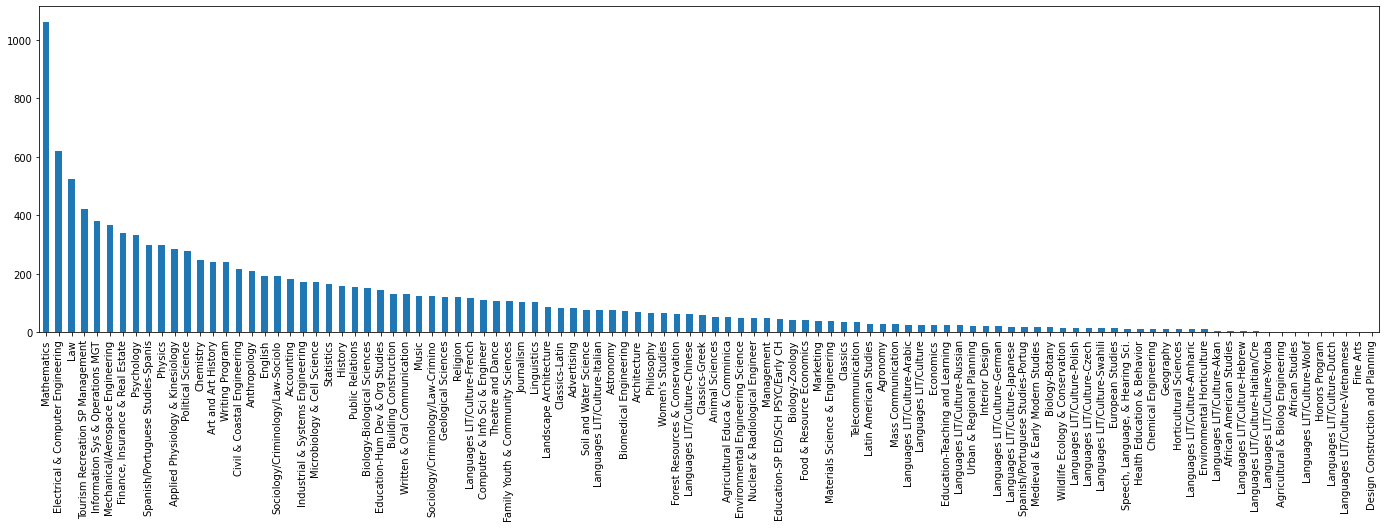

In [ ]:
# Some test graphs for Monday
# By Department Stats across all colleges
data = mondayAssigned["Department"].value_counts()

data.plot(x="Department", y=["Number of Students"], kind="bar", figsize=(24, 6))

Plots below will represent the number of unique sessions found on each day by college.

Monday


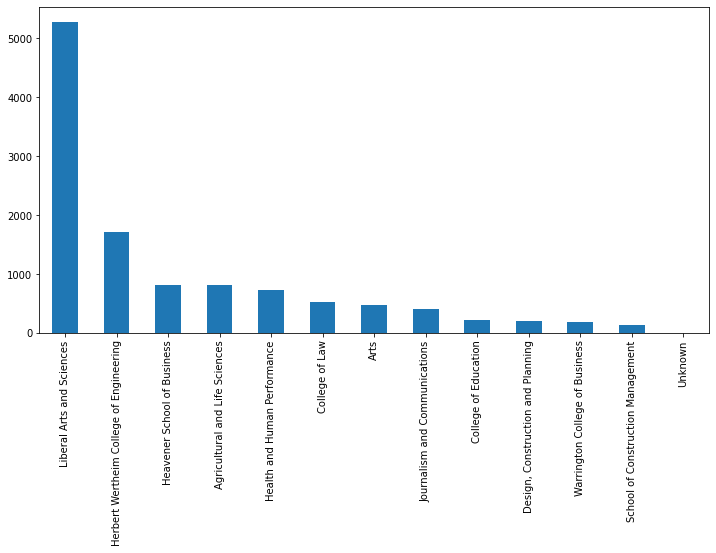

In [ ]:
# By College Stats
print("Monday")
data = mondayAssigned["College"].value_counts()

data.plot(x="College", y=["Number of Students"], kind="bar", figsize=(12, 6))

Tuesday


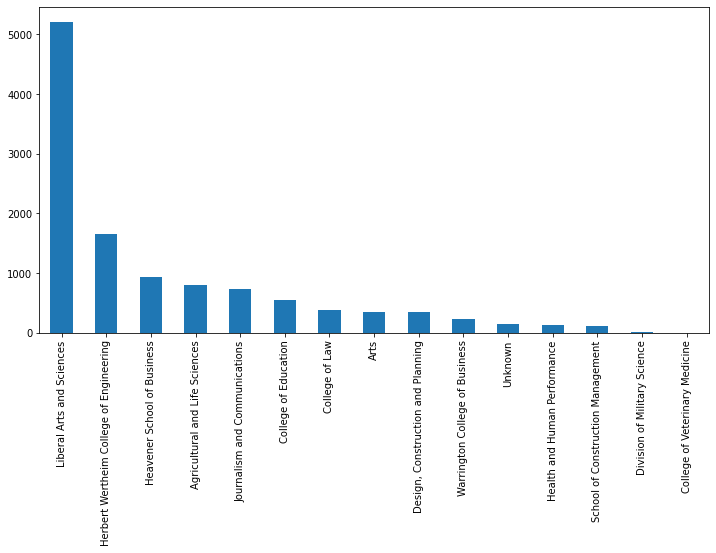

In [ ]:
print("Tuesday")
data = tuesdayAssigned["College"].value_counts()

data.plot(x="College", y=["Number of Students"], kind="bar", figsize=(12, 6))

Wednesday


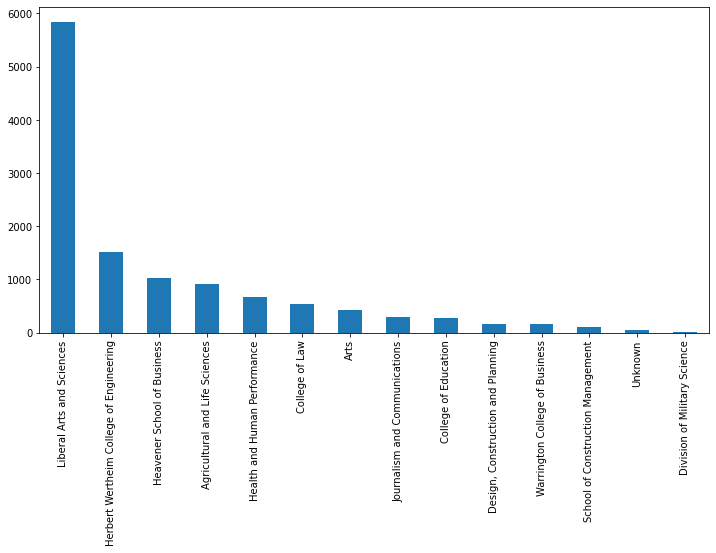

In [ ]:
print("Wednesday")
data = wedsAssigned["College"].value_counts()

data.plot(x="College", y=["Number of Students"], kind="bar", figsize=(12, 6))

Thursday


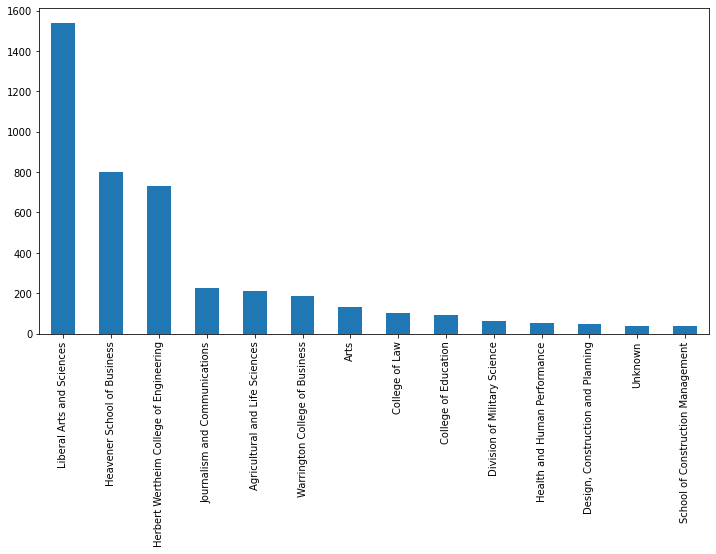

In [ ]:
print("Thursday")
data = thursdayAssigned["College"].value_counts()

data.plot(x="College", y=["Number of Students"], kind="bar", figsize=(12, 6))

Friday


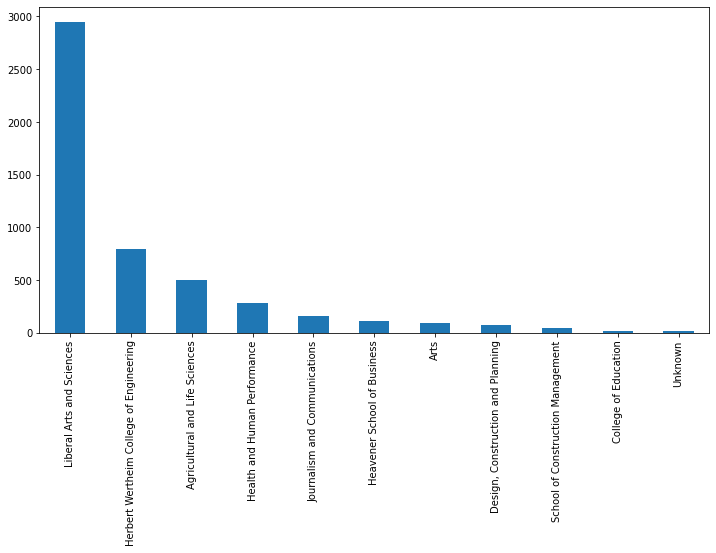

In [ ]:
print("Friday")
data = fridayAssigned["College"].value_counts()

data.plot(x="College", y=["Number of Students"], kind="bar", figsize=(12, 6))

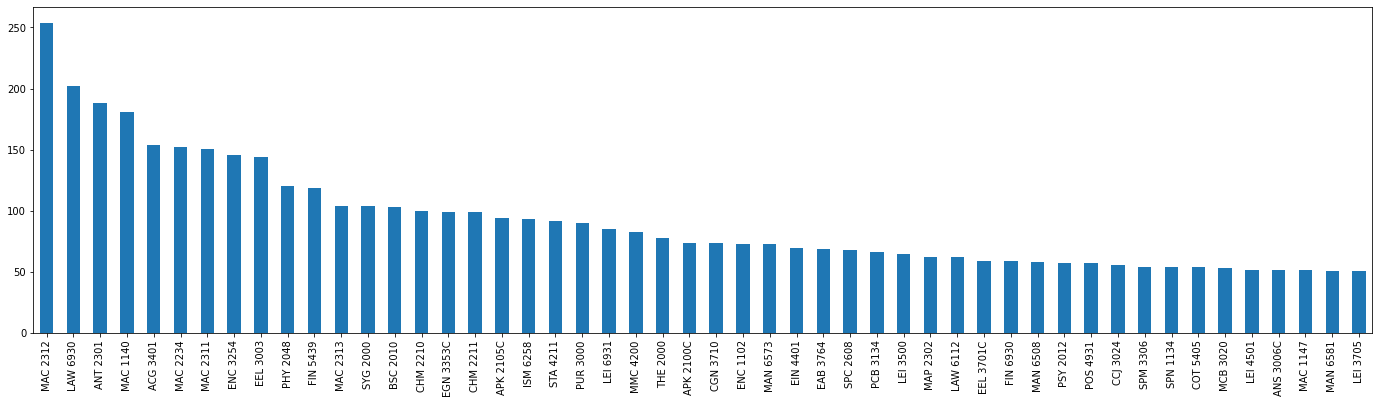

In [ ]:
# By Course Stats plot for Monday
data = mondayAssigned["Course"].value_counts()

data = data[:50]

data.plot(x="Course", y=["Number of Instances"], kind="bar", figsize=(24, 6))

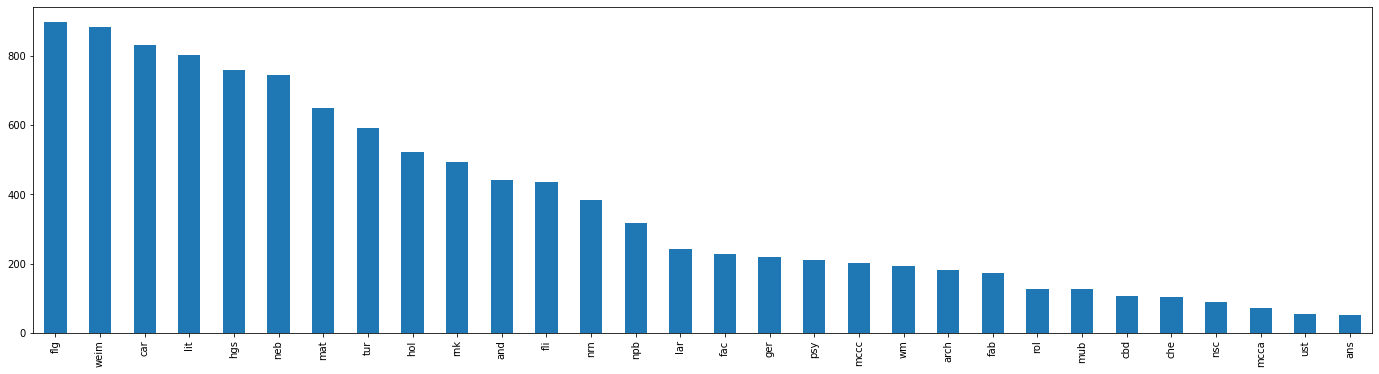

In [ ]:
# By Building Stats plot for Monday
data = mondayAssigned["Bldg"].value_counts()

data = data[:30]

data.plot(x="Building", y=["Number of Instances"], kind="bar", figsize=(24, 6))

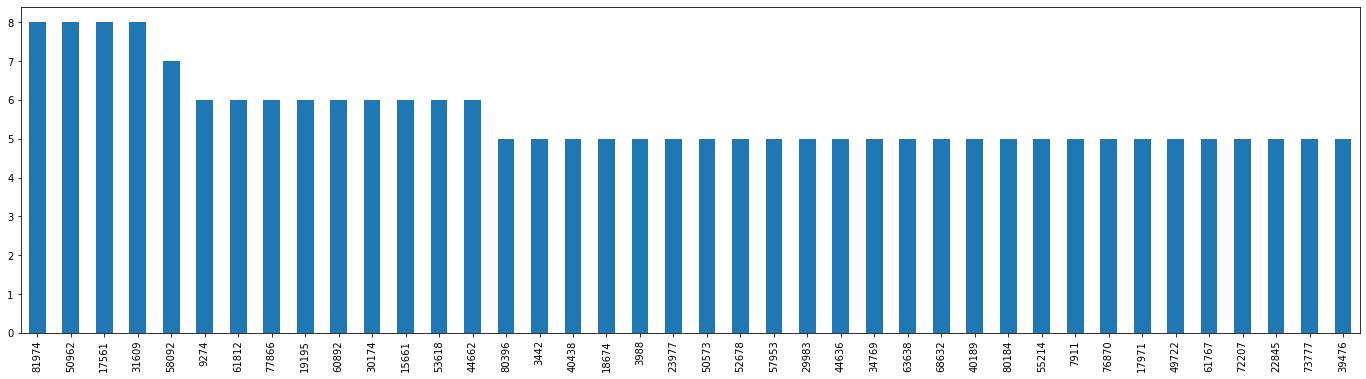

In [ ]:
# By userMAC Stats for Monday
# This was just done out of curiosity
data = mondayAssigned["userMAC"].value_counts()

data = data[:40]

data.plot(x="User", y=["Number of Instances"], kind="bar", figsize=(24, 6))

In [ ]:
# Merging A9-13
# https://www.geeksforgeeks.org/how-to-combine-two-dataframe-in-python-pandas/

frames = [mondayAssigned, tuesdayAssigned, wedsAssigned, thursdayAssigned, fridayAssigned]
  
schoolWeek = pd.concat(frames)
schoolWeek = schoolWeek.drop_duplicates(subset = ['userMAC', 'Period'], keep = 'last').reset_index(drop = True)

Monday-Friday


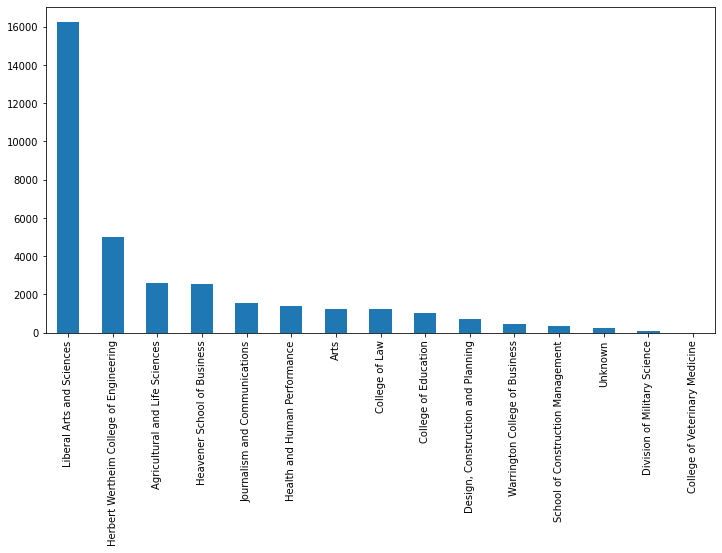

In [ ]:
# prints week long college stats
print("Monday-Friday")
data = schoolWeek["College"].value_counts()

data.plot(x="College", y=["Number of Students"], kind="bar", figsize=(12, 6))

Monday-Friday


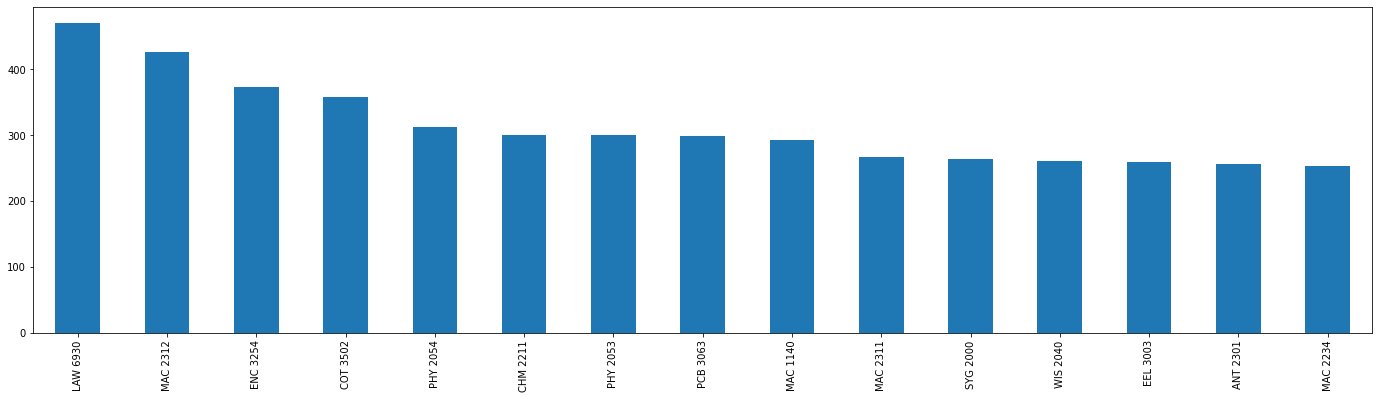

In [ ]:
# Looking at most counted courses during the week
print("Monday-Friday")
data = schoolWeek["Course"].value_counts()

data = data[:15]

data.plot(x="Course", y=["Number of Students"], kind="bar", figsize=(24, 6))

Monday-Friday


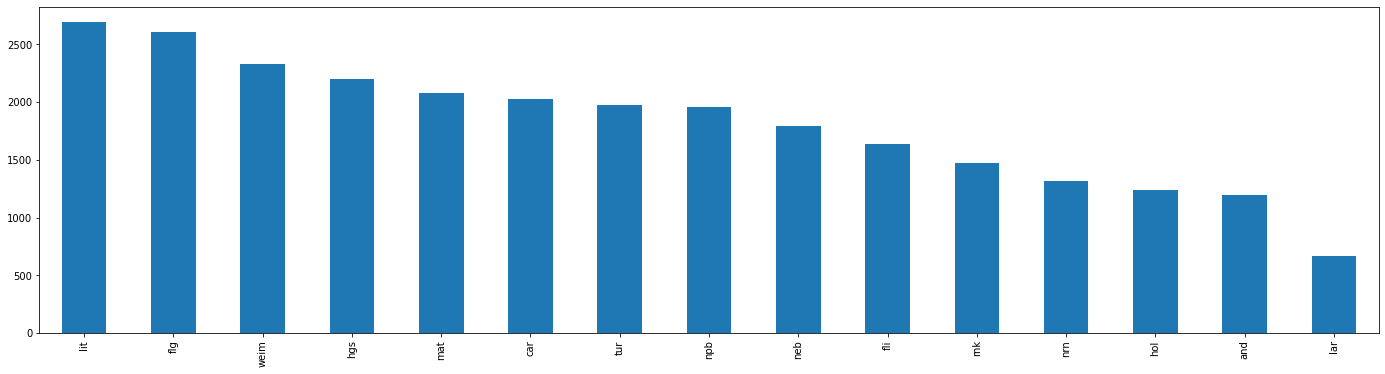

In [ ]:
# looking at most counted buildings during the week
print("Monday-Friday")
data = schoolWeek["Bldg"].value_counts()

data = data[:15]

data.plot(x="Building", y=["Number of Students"], kind="bar", figsize=(24, 6))

Monday-Friday


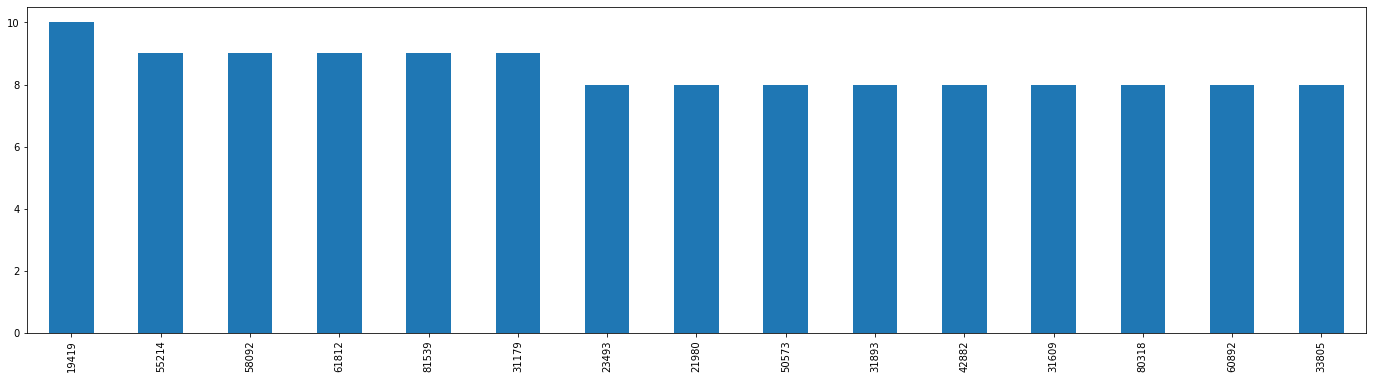

In [ ]:
# looking at most counted userMACs during the week
print("Monday-Friday")
data = schoolWeek["userMAC"].value_counts()

data = data[:15]

data.plot(x="User", y=["Number of Students"], kind="bar", figsize=(24, 6))

### Classification - UserMAC College Assignment and Visuals

This is the **assignment** of students into their colleges.

In [ ]:
# Assigning each userMAC a college
# https://stackoverflow.com/questions/52073054/group-by-a-column-to-find-the-most-frequent-value-in-another-column

# groups the week long dataframe by userMAC and then counts how many times they are associated with a college
assign = schoolWeek.groupby("userMAC")["College"].value_counts().reset_index(name="count")

display(assign)

# NOTE: Some students could have a total count of 1 across all colleges
# could refer to a professor or faculty member, tough to fully tell
# could only limit to 3 or total counts, but this would reduce data
# also there is the chance that equal counts can occur (i.e. possible double major or minor)

# drops the duplicates, top value from previous count should be most frequent college
# therefore the lower counts for the same userMAC will be dropped
assign = assign.drop_duplicates("userMAC")[["userMAC","College"]]

display(assign)

,userMAC,College,count
0,48,"Design, Construction and Planning",2
1,51,Liberal Arts and Sciences,2
2,69,Liberal Arts and Sciences,2
3,69,Herbert Wertheim College of Engineering,1
4,89,Herbert Wertheim College of Engineering,2
...,...,...,...
23140,86317,Liberal Arts and Sciences,2
23141,86319,Liberal Arts and Sciences,1
23142,86325,Herbert Wertheim College of Engineering,2
23143,86327,"Design, Construction and Planning",1


,userMAC,College
0,48,"Design, Construction and Planning"
1,51,Liberal Arts and Sciences
2,69,Liberal Arts and Sciences
4,89,Herbert Wertheim College of Engineering
6,90,Liberal Arts and Sciences
...,...,...
23140,86317,Liberal Arts and Sciences
23141,86319,Liberal Arts and Sciences
23142,86325,Herbert Wertheim College of Engineering
23143,86327,"Design, Construction and Planning"


In [ ]:
print("College Distribution")
data = assign["College"].value_counts()

# shows the population hy college found by the classifcation algorithm
display(data)

College Distribution


Liberal Arts and Sciences                  7382
Herbert Wertheim College of Engineering    2634
Agricultural and Life Sciences             1788
Heavener School of Business                1358
Arts                                        754
Health and Human Performance                697
Journalism and Communications               689
College of Education                        664
College of Law                              662
Design, Construction and Planning           427
Warrington College of Business              197
Unknown                                     116
School of Construction Management            73
Division of Military Science                 56
Name: College, dtype: int64

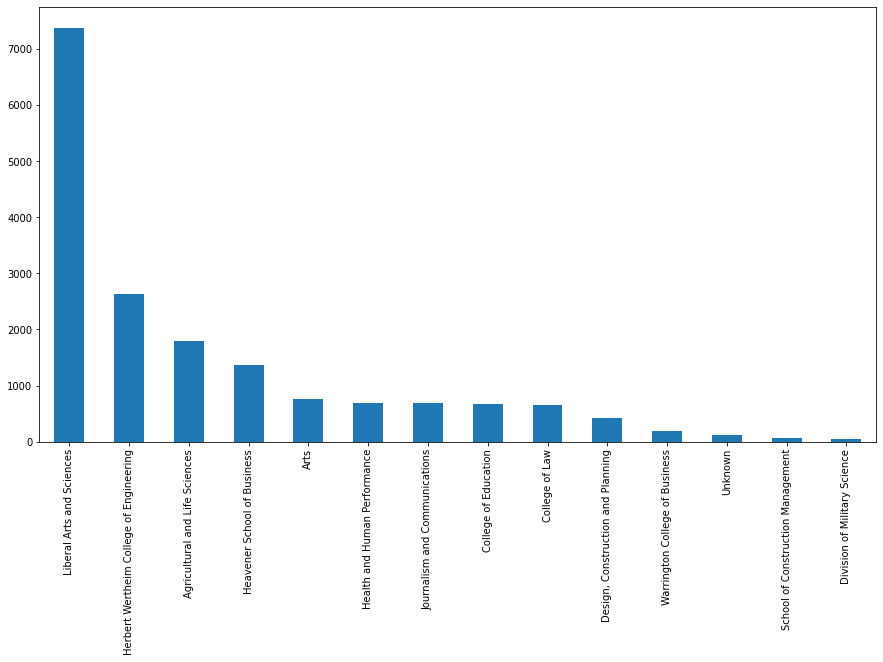

In [ ]:
# visual of above counts
data.plot(kind="bar", figsize=(15, 8))

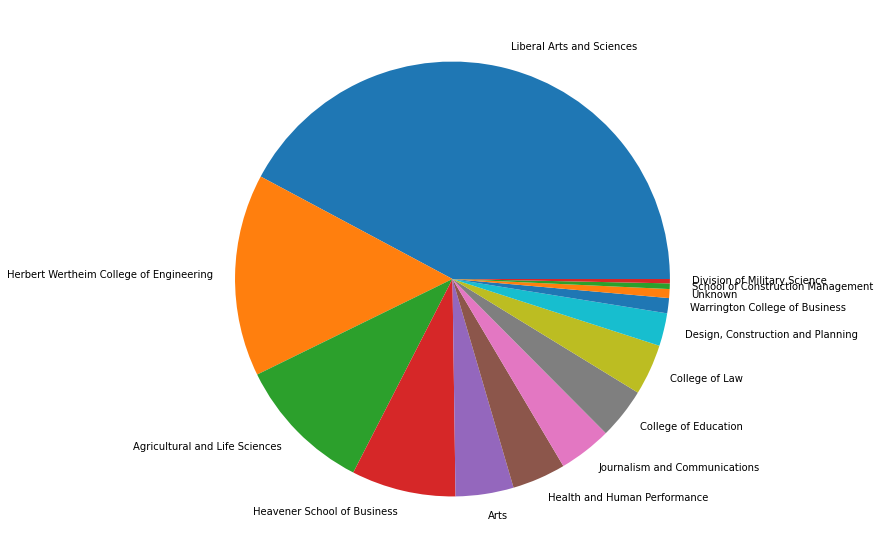

In [ ]:
# pie chart representation of the above bar graph
data.plot(kind="pie", figsize=(15, 10), legend=False, xlabel="", ylabel="")

### College Insights Criteria

Categories:

gyms: rfc, swc

libs: lbw, msl, sma

dining halls: dinefreshfood, fsf

### Classification - Insights Functions

In [ ]:
def insightsClean(df):
  # only keep one pair of userMAC and building, if you go to a different room in the gym it shouldn't mean you went to the gym twice
  # also I think counting someone's gym time once for the day should be fine to give a general understanding of trend
  once = df.drop_duplicates(subset = ['userMAC', 'Building'], keep = 'last').reset_index(drop = True)

  # getting rid of unused columns to make viewing dataframe easier
  temp = once.drop(columns=['deviceType', 'startTimeF', 'endTimeF'])

  # only keeping buildings from the specified locations (libraries, gyms, and dining halls)
  temp = temp.drop(temp[(temp["Building"] != "rfc") & (temp["Building"] != "swc") 
                        & (temp["Building"] != "dinefreshfood") & (temp["Building"] != "fsf") 
                        & (temp["Building"] != "lbw") & (temp["Building"] != "msl") 
                        & (temp["Building"] != "sma") & (temp["Building"] != "bwc")].index)

  return temp

In [ ]:
# "prefix_lat_lon_name_category" does not provide many housing options
# hume commons is a common space at 

def dormClean(df):
  # only keep one pair of userMAC and building, if you go to a different room in the gym it shouldn't mean you went to the gym twice
  # also I think counting someone's gym time once for the day should be fine to give a general understanding of trend
  once = df.drop_duplicates(subset = ['userMAC', 'Building'], keep = 'last').reset_index(drop = True)

  # getting rid of unused columns to make viewing dataframe easier
  dorm = once.drop(columns=['deviceType', 'startTimeF', 'endTimeF'])

  # only keeping buildings from the "housing" specification in "prefix_lat_lon_name_category" besides the president's house
  # unfortunate that there are not more dorm related buildings in their prefix sheet 
  dorm = dorm.drop(dorm[(dorm["Building"] != "ben") & (dorm["Building"] != "bro") & (dorm["Building"] != "hume") & (dorm["Building"] != "jen")].index)

  return dorm

In [ ]:
# clean cleaneda7-13 for gyms, libraries, dining halls
# https://stackoverflow.com/questions/52456874/drop-rows-on-multiple-conditions-in-pandas-dataframe

# the cleaned dataframes for each seven days are used
# the non-classtime dataframes are used since it does not matter when someone goes to the gym, lib, dining hall, etc.
# a cleaning function described above is run for each of the seven days
insightsA7 = insightsClean(cleanedA7)
insightsA8 = insightsClean(cleanedA8)
insightsA9 = insightsClean(cleanedA9)
insightsA10 = insightsClean(cleanedA10)
insightsA11 = insightsClean(cleanedA11)
insightsA12 = insightsClean(cleanedA12)
insightsA13 = insightsClean(cleanedA13)

In [ ]:
# creates a week long inights dataframe
insightFrames = [insightsA7, insightsA8, insightsA9, insightsA10, insightsA11, insightsA12, insightsA13]
  
insightsWeek = pd.concat(insightFrames)

In [ ]:
# clean cleaneda7-13 for dorms

dormsA7 = dormClean(cleanedA7)
dormsA8 = dormClean(cleanedA8)
dormsA9 = dormClean(cleanedA9)
dormsA10 = dormClean(cleanedA10)
dormsA11 = dormClean(cleanedA11)
dormsA12 = dormClean(cleanedA12)
dormsA13 = dormClean(cleanedA13)

In [ ]:
# creates a week long inights dataframe
dormsFrames = [dormsA7, dormsA8, dormsA9, dormsA10, dormsA11, dormsA12, dormsA13]
  
dormsWeek = pd.concat(dormsFrames)

In [ ]:
# associating building prefix with name
# joining when prefix from the buildings df's prefix is equal to the insight df's building
# prefix is equal to building since in the insight df the "Building" column is the prefix 
def buildingID(bds, insights):
  q = """
    SELECT
      building.name, insight.*
    FROM
      bds building
    JOIN
      insights insight
        ON building.prefix = insight.Building
      """

  joined = sqldf(q)

  return joined

In [ ]:
# runs a function to associate building prefixes with their building name
insightsWeek = buildingID(buildings, insightsWeek)

# gets rid of any duplicate columns from the join
insightsWeek = insightsWeek.loc[:,~insightsWeek.columns.duplicated()]

display(insightsWeek)

,name,userMAC,APNAME,APMAC,startTime,endTime,Building,Number
0,Fresh Food,635,dinefreshfood,00:0a:b8:46:67:40,1333962439,1333964135,dinefreshfood,
1,Fresh Food,993,dinefreshfood,00:0a:b8:46:67:40,1334181797,1334183015,dinefreshfood,
2,Fresh Food,1875,dinefreshfood,00:0a:b8:46:67:40,1334076220,1334079658,dinefreshfood,
3,Fresh Food,3181,dinefreshfood,00:0a:b8:46:67:40,1334318348,1334322751,dinefreshfood,
4,Fresh Food,3213,dinefreshfood,00:0a:b8:46:67:40,1334151617,1334153535,dinefreshfood,
...,...,...,...,...,...,...,...,...
37969,SW Recreation Center,86188,swc100hall,00:22:55:e0:80:10,1334342507,1334343556,swc,100
37970,SW Recreation Center,86190,swc100hall,00:22:55:e0:80:10,1334152405,1334155232,swc,100
37971,SW Recreation Center,86311,swc120ahall,00:22:55:e0:72:30,1334261508,1334265053,swc,120a
37972,SW Recreation Center,86311,swc180s,00:17:df:a9:06:b0,1334333132,1334334882,swc,180s


In [ ]:
# runs a function to associate building prefixes with their building name
dormsWeek = buildingID(buildings, dormsWeek)

# gets rid of any duplicate columns from the join
dormsWeek = dormsWeek.loc[:,~dormsWeek.columns.duplicated()]

display(dormsWeek)

,name,userMAC,APNAME,APMAC,startTime,endTime,Building,Number
0,Tolbert Hall,66,ben327hall,88:f0:77:f2:44:c0,1334238723,1334245528,ben,327
1,Tolbert Hall,81,ben217hall,88:f0:77:f2:63:a0,1334137964,1334140981,ben,217
2,Tolbert Hall,81,ben227hall,88:f0:77:f2:6a:40,1333825454,1333829893,ben,227
3,Tolbert Hall,81,ben227hall,88:f0:77:f2:6a:40,1333895057,1333903096,ben,227
4,Tolbert Hall,81,ben335,00:26:99:22:c0:a0,1334335441,1334336703,ben,335
...,...,...,...,...,...,...,...,...
1749,Jennings Hall Office,84450,jen122Atemp,00:23:eb:26:22:40,1334069645,1334070608,jen,122Atemp
1750,Jennings Hall Office,84652,jen122,00:0a:b8:46:64:50,1334349394,1334355877,jen,122
1751,Jennings Hall Office,86180,jen122,00:0a:b8:46:64:50,1334165853,1334166769,jen,122
1752,Jennings Hall Office,86243,jen122,00:0a:b8:46:64:50,1333990358,1333991332,jen,122


In [ ]:
# joining on college assigned students and insights dataframe
# if a college assigned student matches one from the general insights df then there is a join
def buildingID(students, insights):
  q = """
    SELECT
      stu.College, insight.*
    FROM
      students stu
    JOIN
      insights insight
        ON stu.userMAC = insight.userMAC
      """

  joined = sqldf(q)

  return joined

In [ ]:
# since we only classified some of the trace into their colleges we need to only use those students
insightsWeek = buildingID(assign, insightsWeek)

# removes any duplicated columns that may have been created from the join
insightsWeek = insightsWeek.loc[:,~insightsWeek.columns.duplicated()]

display(insightsWeek)

,College,name,userMAC,APNAME,APMAC,startTime,endTime,Building,Number
0,Liberal Arts and Sciences,Library West,69,lbw218,c0:62:6b:d5:35:c0,1334192235,1334202877,lbw,218
1,Liberal Arts and Sciences,Library West,69,lbw328,c0:62:6b:d5:b0:a0,1333900802,1333911067,lbw,328
2,Liberal Arts and Sciences,Library West,90,lbw600,00:16:9d:33:12:70,1333920737,1333924094,lbw,600
3,Liberal Arts and Sciences,Library West,90,lbw600,00:16:9d:33:12:70,1334011617,1334012784,lbw,600
4,Liberal Arts and Sciences,Library West,90,lbw600,00:16:9d:33:12:70,1334258870,1334260552,lbw,600
...,...,...,...,...,...,...,...,...,...
15095,Liberal Arts and Sciences,Library West,86319,lbw204,00:16:9d:e1:ce:d0,1334129485,1334130412,lbw,204
15096,Liberal Arts and Sciences,Library West,86319,lbw218,c0:62:6b:d5:35:c0,1334047258,1334051650,lbw,218
15097,Liberal Arts and Sciences,Library West,86319,lbw218,c0:62:6b:d5:35:c0,1334216679,1334219618,lbw,218
15098,Liberal Arts and Sciences,Smathers Library,86319,sma10b,c0:62:6b:85:be:70,1334131190,1334133225,sma,10b


### Classification - Insights Graphs and Visuals (College vs Building)

To avoid repetitive commeting: The first line of code for the bar graphs will only get the insights for the specified college.

The second line of code will get the value counts for the specified college (ex. the count for how many unique sessions in the chosen college for say Library West).

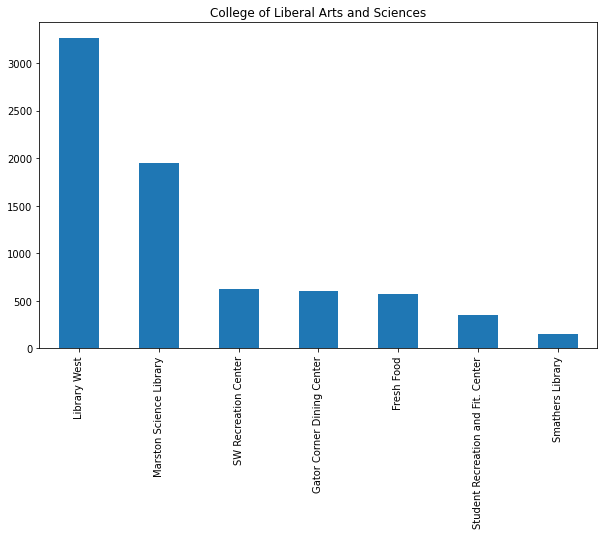

In [ ]:
# only gets the insights values for the xxxx
clas = insightsWeek.loc[insightsWeek["College"] == "Liberal Arts and Sciences"]

# plots unique session counts for the xxxx from the insights week df
clas["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="College of Liberal Arts and Sciences")

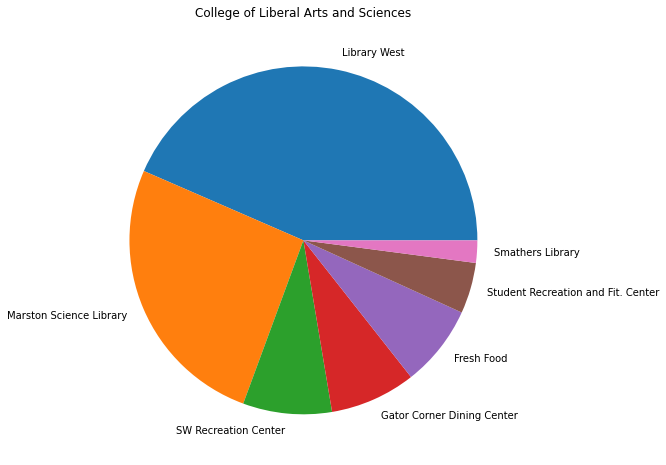

In [ ]:
# another way of presenting the above data (pie chart)
clas["name"].value_counts().plot(kind="pie", figsize=(10, 8), title="College of Liberal Arts and Sciences",legend=False, xlabel="", ylabel="")

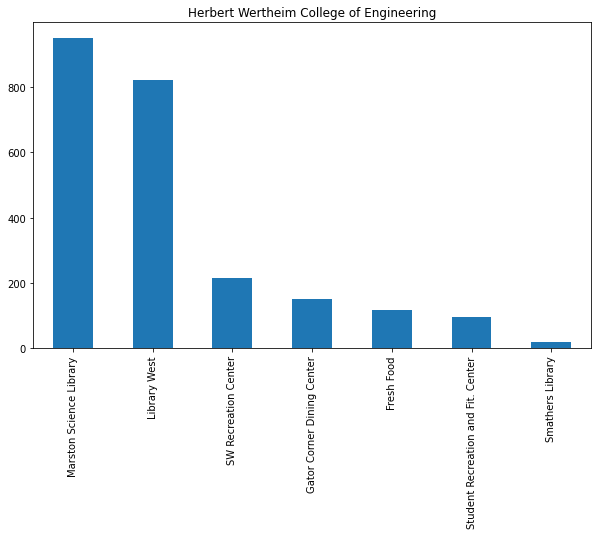

In [ ]:
engineering = insightsWeek.loc[insightsWeek["College"] == "Herbert Wertheim College of Engineering"]

engineering["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Herbert Wertheim College of Engineering")

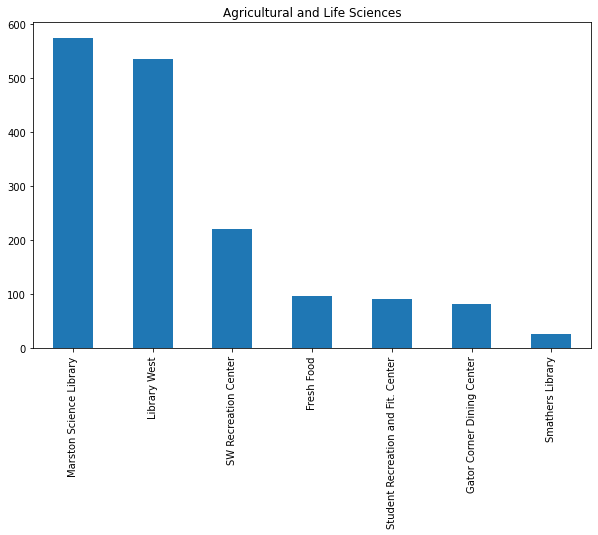

In [ ]:
agri = insightsWeek.loc[insightsWeek["College"] == "Agricultural and Life Sciences"]

agri["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Agricultural and Life Sciences")

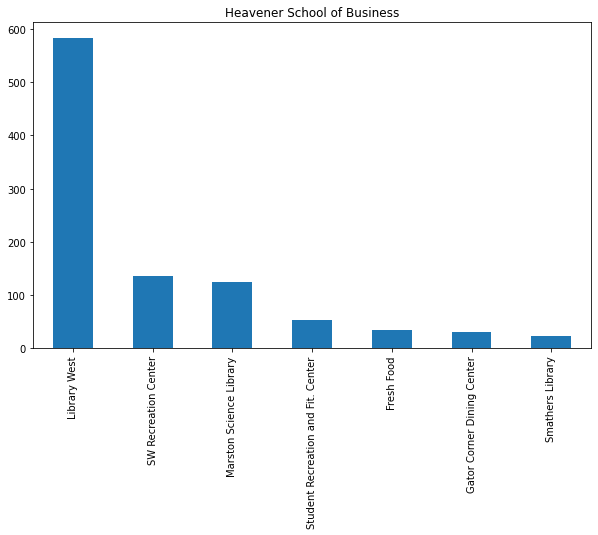

In [ ]:
heavener = insightsWeek.loc[insightsWeek["College"] == "Heavener School of Business"]

heavener["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Heavener School of Business")

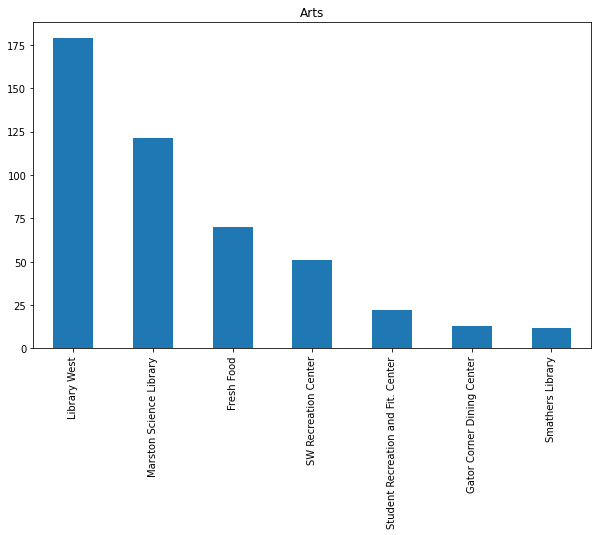

In [ ]:
arts = insightsWeek.loc[insightsWeek["College"] == "Arts"]

arts["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Arts")

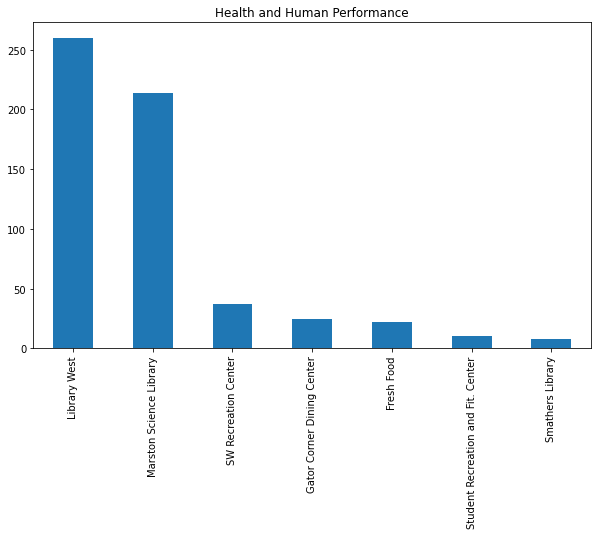

In [ ]:
health = insightsWeek.loc[insightsWeek["College"] == "Health and Human Performance"]

health["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Health and Human Performance")

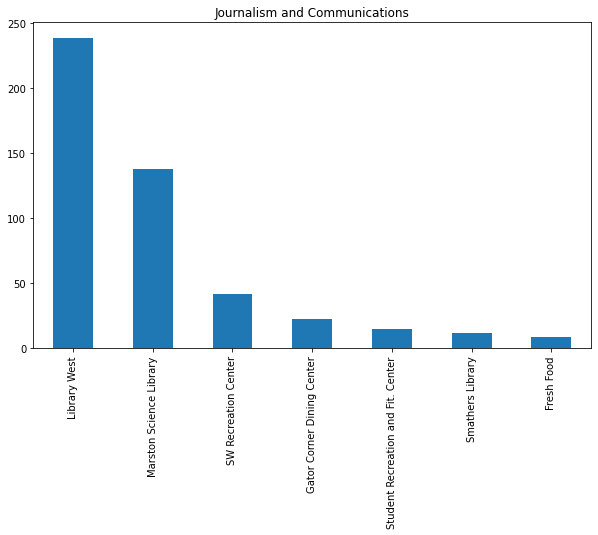

In [ ]:
journalism = insightsWeek.loc[insightsWeek["College"] == "Journalism and Communications"]

journalism["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Journalism and Communications")

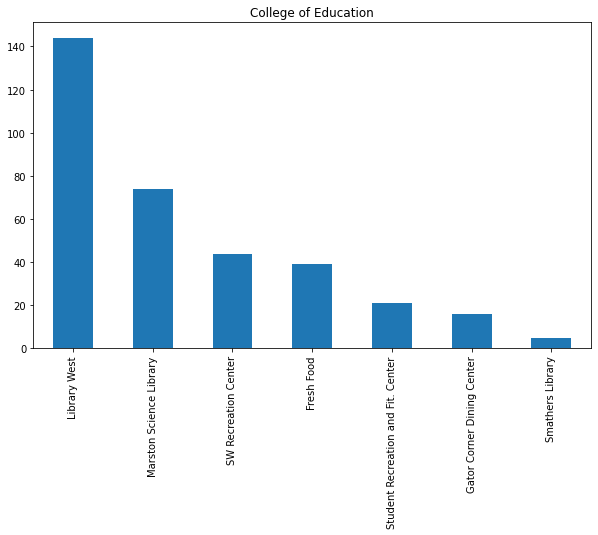

In [ ]:
education = insightsWeek.loc[insightsWeek["College"] == "College of Education"]

education["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="College of Education")

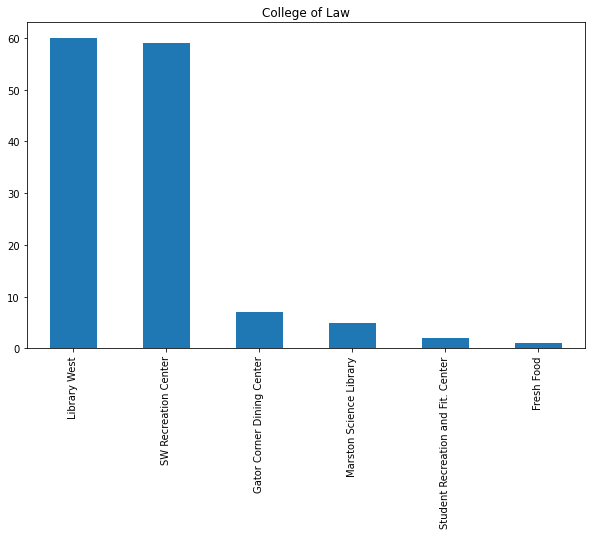

In [ ]:
law = insightsWeek.loc[insightsWeek["College"] == "College of Law"]

law["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="College of Law")

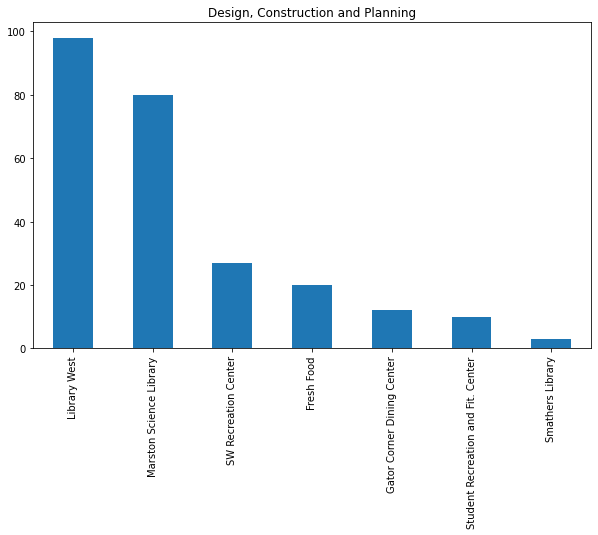

In [ ]:
dcp = insightsWeek.loc[insightsWeek["College"] == "Design, Construction and Planning"]

dcp["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Design, Construction and Planning")

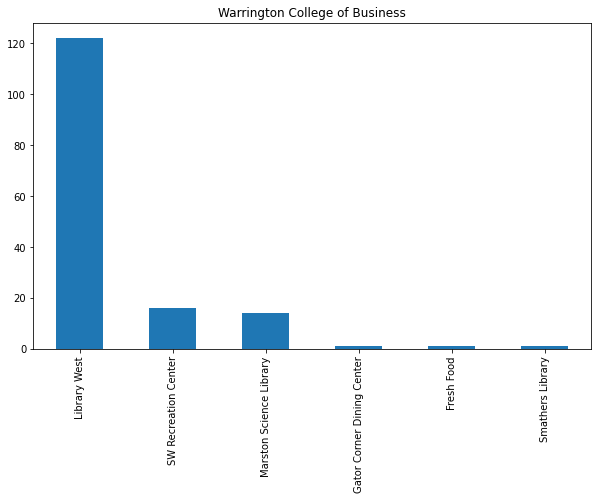

In [ ]:
warrington = insightsWeek.loc[insightsWeek["College"] == "Warrington College of Business"]

warrington["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Warrington College of Business")

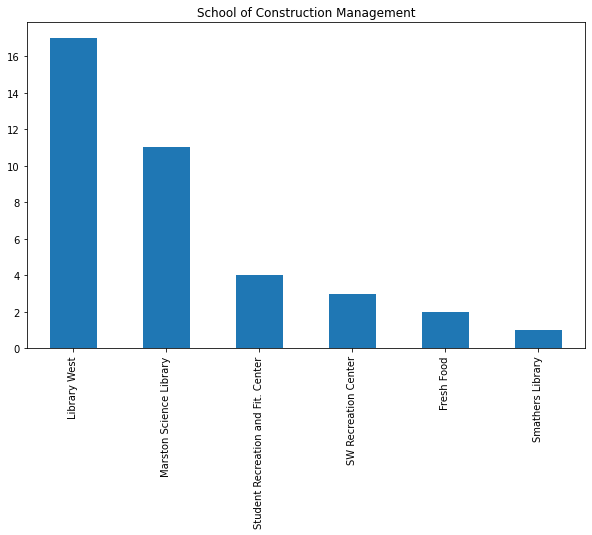

In [ ]:
construction = insightsWeek.loc[insightsWeek["College"] == "School of Construction Management"]

construction["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="School of Construction Management")

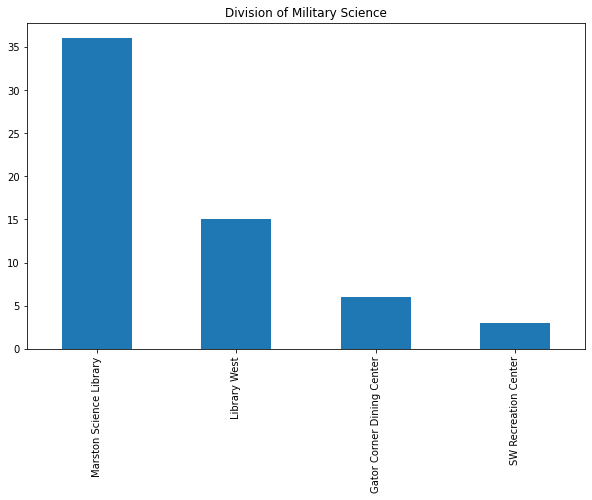

In [ ]:
military = insightsWeek.loc[insightsWeek["College"] == "Division of Military Science"]

military["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Division of Military Science")

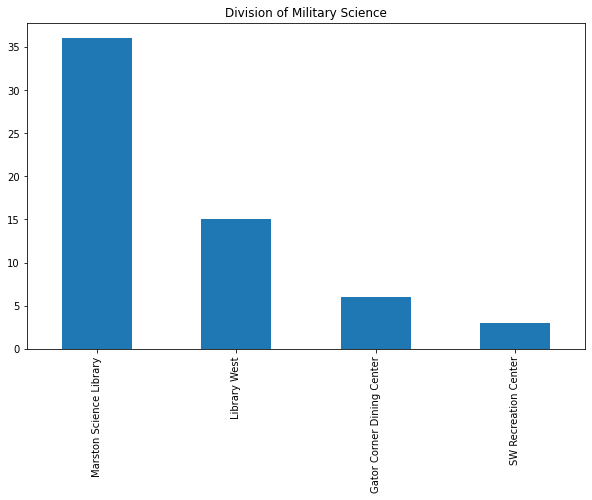

In [ ]:
military = insightsWeek.loc[insightsWeek["College"] == "Division of Military Science"]

military["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Division of Military Science")

### Classification - Insights Graphs and Visuals (College Ratios)

Done through hand calculations from previous data.

In [ ]:
# https://www.javatpoint.com/how-to-create-a-dataframes-in-python

# hand calculated ratios of above data 
# sum of unique sessions of buildings in category / student population count (from our classification algoritm)
ratios = {'College': ['College of Liberal Arts and Sciences', 'Herbert Wertheim College of Engineering', 'Agricultural and Life Sciences', 'Heavener School of Business', 'Arts']
          , 'Gyms': [0.13, 0.12, 0.17, 0.14, 0.10]
          , 'Libs': [0.73, 0.68, 0.63, 0.54, 0.41]
          , 'Dining Halls': [0.15, 0.10, 0.10, 0.05, 0.11]}

ratioInsights = pd.DataFrame(ratios)

display(ratioInsights)

,College,Gyms,Libs,Dining Halls
0,College of Liberal Arts and Sciences,0.13,0.73,0.15
1,Herbert Wertheim College of Engineering,0.12,0.68,0.10
2,Agricultural and Life Sciences,0.17,0.63,0.10
3,Heavener School of Business,0.14,0.54,0.05
4,Arts,0.10,0.41,0.11


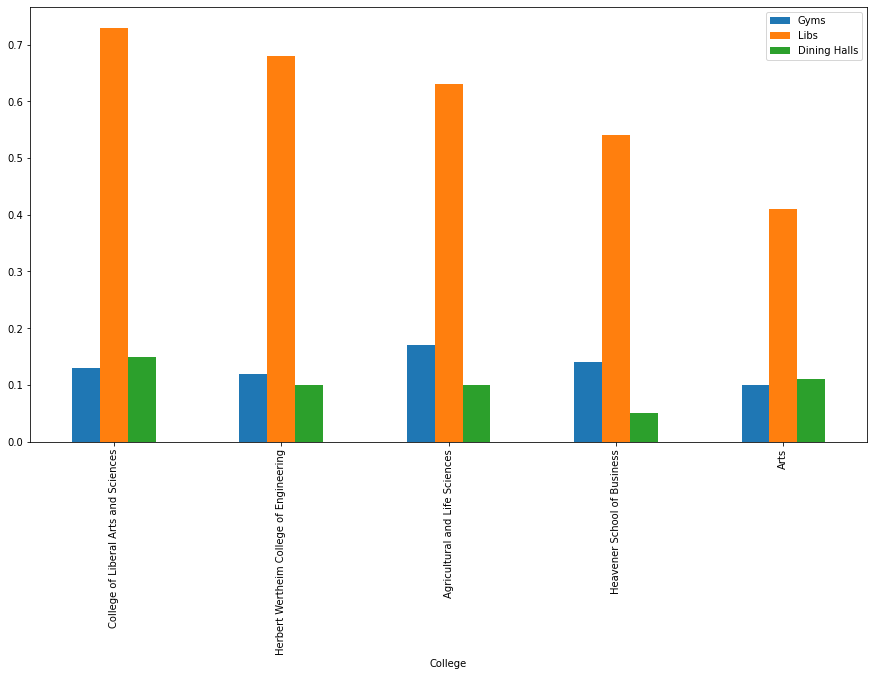

In [ ]:
# https://www.geeksforgeeks.org/plot-multiple-columns-of-pandas-dataframe-on-bar-chart-with-matplotlib/
# plots the values from the top-5 populated colleges by each chosen insight category
ratioInsights.plot(x="College", y=["Gyms", "Libs", "Dining Halls"], kind="bar", figsize=(15, 8))

### Classification - Dorm Insights Graphs and Visuals (College vs Building)

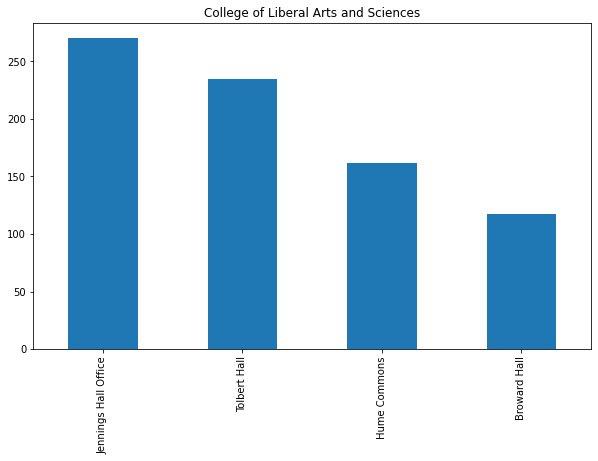

In [ ]:
# only gets the insights values for the xxxx
clasDorms = dormsWeek.loc[insightsWeek["College"] == "Liberal Arts and Sciences"]

# plots unique session counts for the xxxx from the insights week df
clasDorms["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="College of Liberal Arts and Sciences")

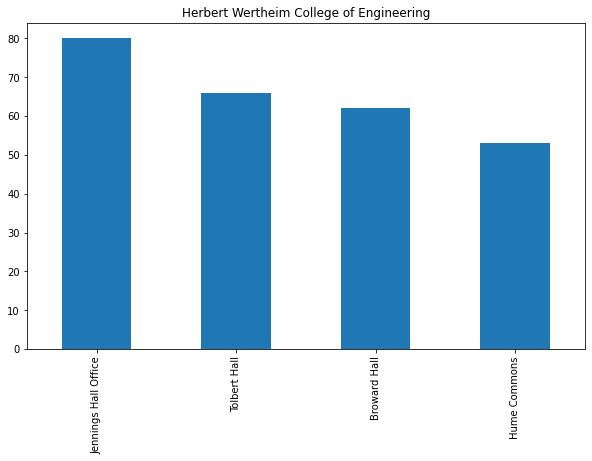

In [ ]:
engineeringDorms = dormsWeek.loc[insightsWeek["College"] == "Herbert Wertheim College of Engineering"]

engineeringDorms["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Herbert Wertheim College of Engineering")

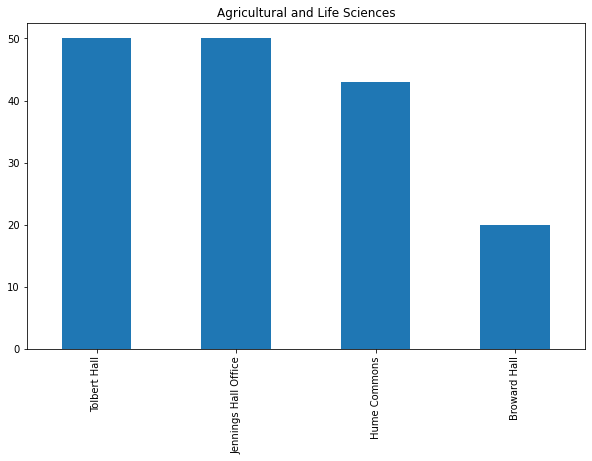

In [ ]:
agriDorms = dormsWeek.loc[insightsWeek["College"] == "Agricultural and Life Sciences"]

agriDorms["name"].value_counts().plot(kind="bar", figsize=(10, 6), title="Agricultural and Life Sciences")

### Predictive Modeling - Functions and Scatter Plot

In [ ]:
# Data Cleaning (Remove irrelevant features, assign numbers to strings (i.e. Colleges, Courses, etc.))

# **NOTE**: With the way the labels are encoded right now, there may be some issues where the model captures relationships that are not reflective of the actual data
# Example: Monday is assigned to 1, and Tuesday is Assigned to 2, this may cause the model to capture a relationship where Tuesday > Monday
# Solution: Will implement one-hot label encoding to prevent this issue, for final report
# Potential Issues: A high amount of features will be required for one hot encoding, how will it be graphed and what impact will the amount of features have for SVM? 
# With 3 features, SVM already has a runtime of >3m, will test in the future

def getDuration(row):
  return row['endTime'] - row['startTime']

def assignNum(param, array, row):
  index = np.where(array == row[param])
  return np.asscalar(index[0])

def dataClean(df):
  cleaned = df.drop(columns=['deviceType', 'Building', 'Number', 'Sect', 'Room', 'CourseTitle', 'Department', 'APNAME', 'College 2'])
  cleaned = cleaned.drop(cleaned[cleaned.College.str.contains("Unknown", na=False)].index)
  cleaned['Duration'] = cleaned.apply(lambda row: getDuration(row), axis=1)
  build = cleaned.Bldg.unique()
  college = cleaned.College.unique()
  day = cleaned.Day.unique()
  period = cleaned.Period.unique()
  course = cleaned.Course.unique()
  cleaned['BuildNum'] = cleaned.apply(lambda row: assignNum('Bldg', build, row), axis = 1)
  cleaned['CollegeNum'] = cleaned.apply(lambda row: assignNum('College', college, row), axis = 1)
  cleaned['DayNum'] = cleaned.apply(lambda row: assignNum('Day', day, row), axis = 1)
  cleaned['PeriodNum'] = cleaned.apply(lambda row: assignNum('Period', period, row), axis = 1)
  cleaned['CourseNum'] = cleaned.apply(lambda row: assignNum('Course', course, row), axis = 1)
  cleaned = cleaned.drop(columns=['startTime', 'endTime', 'Bldg', 'userMAC', 'Start', 'End', 'Day', 'Period', 'Course', 'College'])
  
  return cleaned

In [ ]:
trainingData = dataClean(schoolWeek)

# Correlation between variables 
correlation_matrix = trainingData.corr()
display(correlation_matrix)

# Features and Target Variable

# Using only data found from WLAN traces
#X = trainingData.drop(['CollegeNum', 'CourseNum'], axis=1)
#y = trainingData['CollegeNum']

# Remove possibly irrelevant features
X = trainingData.drop(['CollegeNum', 'CourseNum', 'Duration'], axis=1)
y = trainingData['CollegeNum']

# Supplemented with course number
#X = trainingData.drop(['CollegeNum', 'Duration'], axis=1)
#y = trainingData['CollegeNum']

#display(X)
#display(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


,Duration,BuildNum,CollegeNum,DayNum,PeriodNum,CourseNum
Duration,1.000000,0.082392,0.064939,0.063240,0.159942,0.074373
BuildNum,0.082392,1.000000,-0.077752,0.085330,0.053484,0.048288
CollegeNum,0.064939,-0.077752,1.000000,0.120038,0.114245,0.132384
DayNum,0.063240,0.085330,0.120038,1.000000,0.278834,0.738741
PeriodNum,0.159942,0.053484,0.114245,0.278834,1.000000,0.431940
CourseNum,0.074373,0.048288,0.132384,0.738741,0.431940,1.000000


,Method,Training MSE,Training RMSE,Test MSE,Test RMSE,Accuracy (%)
0,K Nearest Neighbors,1.516717,1.231551,1.759913,1.326617,80.15919


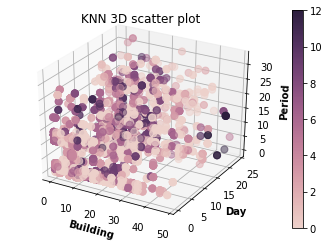

In [ ]:
# Split Data into test and training sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=500)

# Reference Link: https://realpython.com/knn-python/
# Create KNN Model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Tests on training data
train_preds = knn_model.predict(X_train)
train_preds = [round(num) for num in train_preds]
knn_train_mse = mean_squared_error(y_train, train_preds)
knn_train_rmse = sqrt(knn_train_mse)

# Testing dataset
test_preds = knn_model.predict(X_test)
test_preds = [round(num) for num in test_preds]
knn_test_mse = mean_squared_error(y_test, test_preds)
knn_test_rmse = sqrt(knn_test_mse)

# Evaluation of Model
accuracy = accuracy_score(y_test,test_preds)*100
knn_results = pd.DataFrame(['K Nearest Neighbors', knn_train_mse, knn_train_rmse, knn_test_mse, knn_test_rmse, accuracy]).transpose()
knn_results.columns = ['Method','Training MSE','Training RMSE','Test MSE','Test RMSE', 'Accuracy (%)']
display(knn_results)

# Plot
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
ax = plt.axes(projection="3d")
plt.title("KNN 3D scatter plot")
ax.set_xlabel('Building', fontweight ='bold')
ax.set_ylabel('Day', fontweight ='bold')
ax.set_zlabel('Period', fontweight ='bold')
points = ax.scatter3D( X_test.iloc[:, 0], X_test.iloc[:, 1], X_test.iloc[:,2], c=test_preds, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

,Method,Training MSE,Training RMSE,Test MSE,Test RMSE,Accuracy (%)
0,Support Vector Machine,12.071863,3.474459,12.429233,3.474459,63.502171


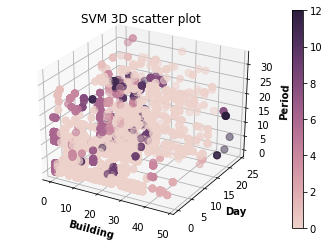

In [ ]:
# Reference Link: https://analyticsindiamag.com/understanding-the-basics-of-svm-with-example-and-python-implementation/
# Create SVM Model
SupportVectorClassModel = SVC()
SupportVectorClassModel.fit(X_train,y_train)

# Tests on training data
train_preds = SupportVectorClassModel.predict(X_train)
train_preds = [round(num) for num in train_preds]
svm_train_mse = mean_squared_error(y_train, train_preds)
svm_train_rmse = sqrt(svm_train_mse)

# Testing dataset
test_preds = SupportVectorClassModel.predict(X_test)
svm_test_mse = mean_squared_error(y_test, test_preds)
svm_test_rmse = sqrt(svm_train_mse)
test_preds = [round(num) for num in test_preds]

accuracy = accuracy_score(y_test,test_preds)*100

# Evaluation of Model
svm_results = pd.DataFrame(['Support Vector Machine', svm_train_mse, svm_train_rmse, svm_test_mse, svm_test_rmse, accuracy]).transpose()
svm_results.columns = ['Method','Training MSE','Training RMSE','Test MSE','Test RMSE', 'Accuracy (%)']
display(svm_results)

# Plot
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
ax = plt.axes(projection="3d")
plt.title("SVM 3D scatter plot")
ax.set_xlabel('Building', fontweight ='bold')
ax.set_ylabel('Day', fontweight ='bold')
ax.set_zlabel('Period', fontweight ='bold')
points = ax.scatter3D( X_test.iloc[:, 0], X_test.iloc[:, 1], X_test.iloc[:,2], c=test_preds, s=50, cmap=cmap)
f.colorbar(points)
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


,Count,Duration,DayNum
userMAC,,,
51,2,8795,22
69,2,7148,22
90,2,5758,0
92,1,3656,0
116,1,2905,3
...,...,...,...
86309,1,1198,0
86312,2,5954,0
86317,2,5048,22


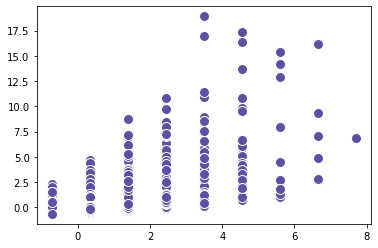

In [ ]:
# Clustering Attempt (WIP), I don't think there are any real discernible patterns in the data so far, I may have to be more selective with the features used,
# Or switch algorithms. This could possibly be a lost cause because all traces are >15 mins, and plots of the data so far show that the data points are on random points in the vector space
def clusterClean(college, df):
    cleaned = df.drop(columns=['deviceType', 'Building', 'Number', 'Sect', 'Room', 'CourseTitle', 'Department', 'APNAME', 'College 2'])
    cleaned = cleaned.drop(cleaned[cleaned.College.str.contains("Unknown", na=False)].index)
    cleaned = cleaned[cleaned.College.str.contains(college,na=False)]
    day = cleaned.Day.unique()
    cleaned['DayNum'] = cleaned.apply(lambda row: assignNum('Day', day, row), axis = 1)
    cleaned['Duration'] = cleaned.apply(lambda row: getDuration(row), axis=1)
    cleaned['Count'] = 1
    numSessions = cleaned.groupby("userMAC")['Count'].sum()
    totalDur = cleaned.groupby("userMAC")['Duration'].sum()
    dayCount = cleaned.groupby("userMAC")['DayNum'].sum()
    real = pd.concat([numSessions, totalDur, dayCount ], axis=1)
    #display(real)
    d = preprocessing.normalize(real)
    normalized_clean = pd.DataFrame(d)
    # Group by userMAC, add total session count, duration, and unique days logged in
    return real

# Use data to run K-Medoids algo 

cluster = clusterClean("Liberal Arts", schoolWeek)
display(cluster)

cluster_data = scale(cluster)

KMobj = KMedoids(n_clusters=2).fit(cluster_data)

labels = KMobj.labels_

unq_lab = set(labels)

colors_plot = [
 plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unq_lab))
]

for k, col in zip(unq_lab, colors_plot):
    class_member_mask = labels == k

xy = cluster_data[class_member_mask]

plt.plot( xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='white',markersize=10);

# Clusters empty, data possibly isn't suitable for clustering? Or model is setup wrong, will continue looking into for future report